<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Prediction

--- 
# Notebook 2

This notebook consists of:
- Feature Engineering
- Modelling
---

# 1. Loading the Datasets

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity

In [2]:
# load datasets
weather = pd.read_csv('../assets/weather_clean.csv')
train = pd.read_csv('../assets/train_clean.csv')
test = pd.read_csv('../assets/test_clean.csv')
spray = pd.read_csv('../assets/spray_clean.csv')
sampleSubmission = pd.read_csv('../assets/sampleSubmission.csv')

In [3]:
# load the map
mapdata = np.loadtxt('../assets/mapdata_copyright_openstreetmap_contributors.txt')
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# 2. Feature Engineering

## 2.1 Clustering on Trap Location & Mosquitos

In [4]:
# create new feature `coords` to combine lat and long
train['coords'] = list(zip(train['latitude'], train['longitude']))

test['coords'] = list(zip(test['latitude'], test['longitude']))

In [5]:
# total numbers of unique trap locations in chicago
print(f"Number of Unique Coords Value - train: {train['coords'].nunique()}")
print(f"Number of Unique Coords Value - test: {test['coords'].nunique()}")

Number of Unique Coords Value - train: 138
Number of Unique Coords Value - test: 151


In [6]:
# total numbers of unique trap in chicago
print(f"Number of Unique Trap - train: {train['trap'].nunique()}")
print(f"Number of Unique Trap - test: {test['trap'].nunique()}")

Number of Unique Trap - train: 136
Number of Unique Trap - test: 149


In [7]:
trap_df = train.groupby([col for col in train.columns if col not in ['wnvpresent','nummosquitos']]).sum().reset_index()

In [8]:
trap_df['wnvpresent'] = trap_df['wnvpresent'].apply(lambda x: 1 if x>0 else x)

In [9]:
trap_df['wnvpresent'].value_counts()

0    8018
1     457
Name: wnvpresent, dtype: int64

In [10]:
# create trap cluster by date and coords
trap_cluster = trap_df.groupby(['date','coords']).mean().copy()

In [11]:
trap_cluster.shape

(4616, 10)

In [12]:
# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier

In [13]:
def scale_minmax(X):
    mm = MinMaxScaler()
    return mm.fit_transform(X)

In [14]:
# plot dd scatter plot
def plot_results_3d(df, cl):
    X = df[['longitude', 'latitude','nummosquitos']]
    X_sc = scale_minmax(X)
    cl.fit(X_sc)
    df['cluster_3d'] = cl.labels_
    sil = silhouette_score(X_sc, cl.labels_)
    print(f"SILHOUETTE SCORE = {sil}")
    
    fig = plt.figure(figsize = (20, 16))
    ax = plt.axes(projection = '3d')
    ax.scatter3D(df['longitude'], df['latitude'], df['nummosquitos'], c=df['cluster_3d'], cmap = 'tab20')
    ax.set_xlabel('longitude', fontsize=15)
    ax.set_ylabel('latitude', fontsize=15)
    ax.set_zlabel('nummosquitos', fontsize=15)
    ax.set_title(f'3D Scatter Plot for Trap Location and Number of Mosquitos with DBSCAN', fontsize=20)
    return plt.show()

In [15]:
trap_cluster[['latitude','longitude','nummosquitos']].head()

latitude  longitude  nummosquitos
date       coords                                                     
2007-05-29 (41.688324, -87.676709)  41.688324 -87.676709           1.0
           (41.720848, -87.666014)  41.720848 -87.666014           3.0
           (41.731922, -87.677512)  41.731922 -87.677512           3.0
           (41.732984, -87.649642)  41.732984 -87.649642           1.0
           (41.862292, -87.64886)   41.862292 -87.648860           1.0

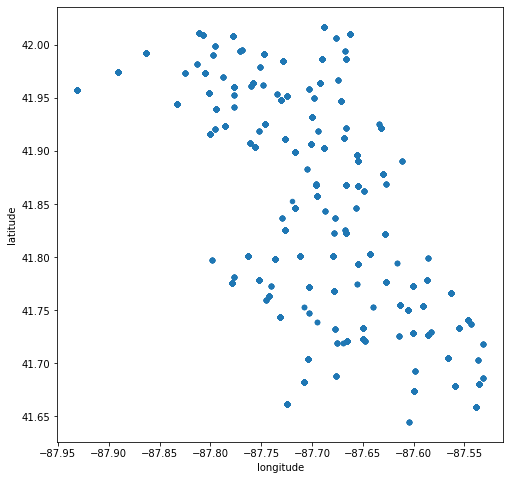

In [16]:
# scatter plot in 2D
trap_cluster[['latitude','longitude']].plot(kind='scatter', x='longitude', y='latitude', figsize=(8,8));

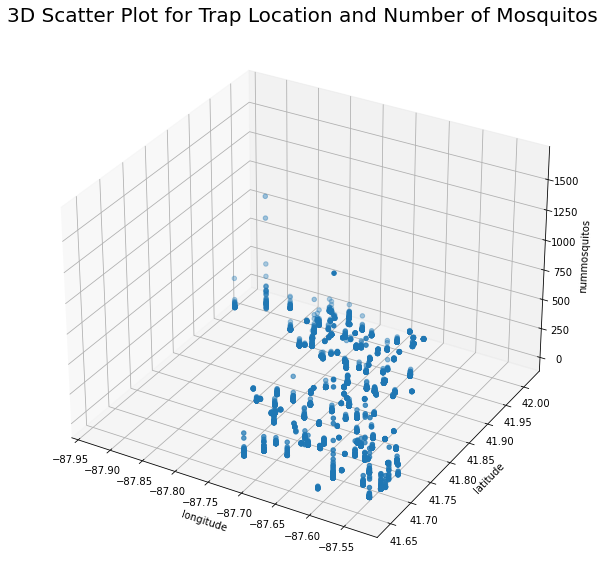

In [17]:
# scatter plot in 3D
fig = plt.figure(figsize = (13, 10))
ax = plt.axes(projection = '3d')
ax.scatter3D(trap_cluster['longitude'], trap_cluster['latitude'], trap_cluster['nummosquitos'], cmap = 'tab20')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_zlabel('nummosquitos')
ax.set_title('3D Scatter Plot for Trap Location and Number of Mosquitos', fontsize=20);

SILHOUETTE SCORE = 0.34118013261741326


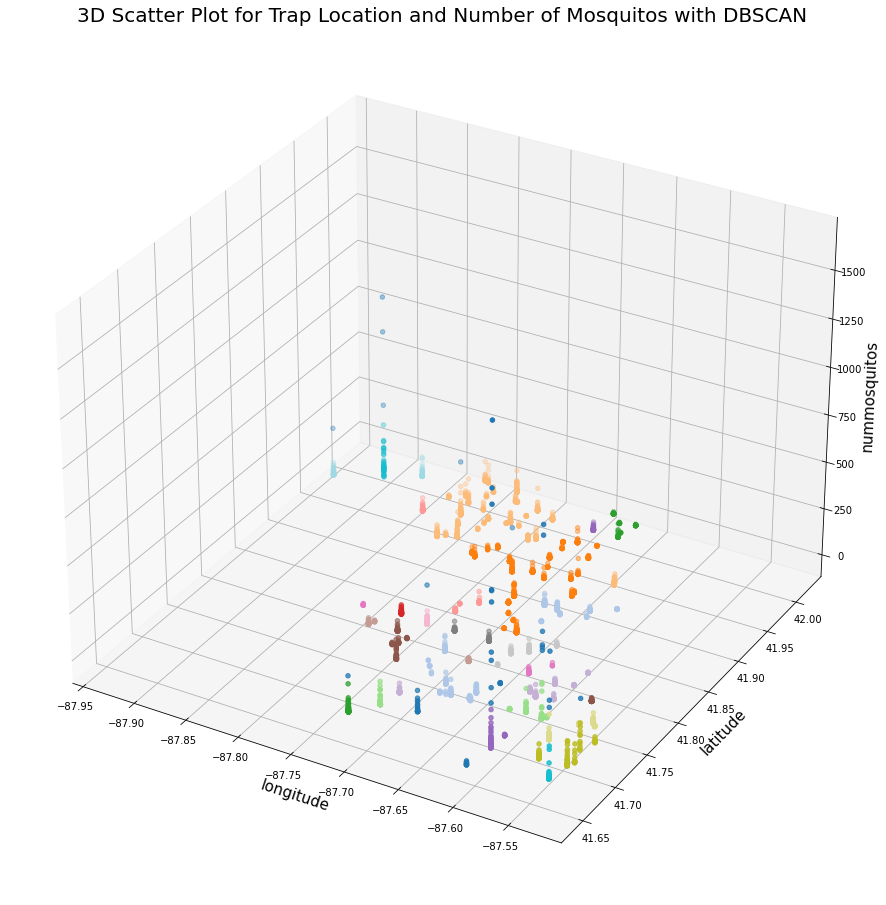

In [18]:
# Clustering using DBSCAN
cl_3d = DBSCAN(min_samples=10, eps=0.058) #0.2 score 0.65
plot_results_3d(trap_cluster, cl_3d)

In [19]:
# numbers of unique cluster
trap_cluster['cluster_3d'].nunique()

38

There are total of 136 trap location in train datasets, and after our clustering, we manage to reduce the trap cluster to 38 for classification model

In [20]:
# check corr
trap_cluster.reset_index().corr()['wnvpresent'].sort_values(ascending=False)

wnvpresent         1.000000
nummosquitos       0.277028
week               0.123610
month              0.120452
year               0.065971
latitude           0.026530
block              0.015153
addressaccuracy    0.012267
day                0.005051
cluster_3d         0.004867
longitude         -0.084046
Name: wnvpresent, dtype: float64

In [21]:
# check cluster min and max value
trap_cluster['cluster_3d'].min(), trap_cluster['cluster_3d'].max()

(-1, 36)

In [22]:
trap_cluster.head(10)

block   latitude  longitude  \
date       coords                                                 
2007-05-29 (41.688324, -87.676709)   22.0  41.688324 -87.676709   
           (41.720848, -87.666014)   17.0  41.720848 -87.666014   
           (41.731922, -87.677512)   22.0  41.731922 -87.677512   
           (41.732984, -87.649642)   89.0  41.732984 -87.649642   
           (41.862292, -87.64886)    11.0  41.862292 -87.648860   
           (41.867108, -87.654224)   11.0  41.867108 -87.654224   
           (41.891118, -87.654491)   25.0  41.891118 -87.654491   
           (41.891126, -87.61156)    53.0  41.891126 -87.611560   
           (41.896282, -87.655232)   11.0  41.896282 -87.655232   
           (41.907645, -87.760886)   15.0  41.907645 -87.760886   

                                    addressaccuracy    year  month  week  \
date       coords                                                          
2007-05-29 (41.688324, -87.676709)              8.0  2007.0    5.0  22.0   
           (41.720848, -87.666014)              9.0  2007.0    5.0  22.0   
           (41.731922, -87.677512)              8.0  2007.0    5.0  22.0   
           (41.732984, -87.649642)              8.0  2007.0    5.0  22.0   
           (41.862292, -87.64886)               8.0  2007.0    5.0  22.0   
           (41.867108, -87.654224)              8.0  2007.0    5.0  22.0   
           (41.891118, -87.654491)              8.0  2007.0    5.0  22.0   
           (41.891126, -87.61156)               5.0  2007.0    5.0  22.0   
           (41.896282, -87.655232)              8.0  2007.0    5.0  22.0   
           (41.907645, -87.760886)              8.0  2007.0    5.0  22.0   

                                     day  nummosquitos  wnvpresent  cluster_3d  
date       coords                                                               
2007-05-29 (41.688324, -87.676709)  29.0           1.0         0.0           0  
           (41.720848, -87.666014)  29.0           3.0         0.0           1  
           (41.731922, -87.677512)  29.0           3.0         0.0           1  
           (41.732984, -87.649642)  29.0           1.0         0.0           1  
           (41.862292, -87.64886)   29.0           1.0         0.0           2  
           (41.867108, -87.654224)  29.0           1.5         0.0           2  
           (41.891118, -87.654491)  29.0           1.0         0.0           3  
           (41.891126, -87.61156)   29.0           1.5         0.0           2  
           (41.896282, -87.655232)  29.0           1.0         0.0           3  
           (41.907645, -87.760886)  29.0           1.0         0.0           4

In [23]:
trap_cluster_mean = trap_cluster.groupby(['coords','cluster_3d']).mean()

# check numbers of coords with multiple cluster_3d
trap_cluster_mean.loc[trap_cluster_mean.index.get_level_values('coords').duplicated(keep = False)].head(10)

block   latitude  longitude  \
coords                  cluster_3d                                
(41.662014, -87.724608) -1           42.0  41.662014 -87.724608   
                         8           42.0  41.662014 -87.724608   
(41.673408, -87.599862) -1           12.0  41.673408 -87.599862   
                         15          12.0  41.673408 -87.599862   
(41.702724, -87.536497) -1           11.0  41.702724 -87.536497   
                         30          11.0  41.702724 -87.536497   
(41.704572, -87.565666) -1           24.0  41.704572 -87.565666   
                         32          24.0  41.704572 -87.565666   
(41.726465, -87.585413) -1           10.0  41.726465 -87.585413   
                         10          10.0  41.726465 -87.585413   

                                    addressaccuracy         year     month  \
coords                  cluster_3d                                           
(41.662014, -87.724608) -1                      8.0  2009.000000  7.000000   
                         8                      8.0  2009.984615  7.538462   
(41.673408, -87.599862) -1                      5.0  2007.000000  8.300000   
                         15                     5.0  2010.535714  7.535714   
(41.702724, -87.536497) -1                      5.0  2007.000000  8.000000   
                         30                     5.0  2007.000000  8.545455   
(41.704572, -87.565666) -1                      8.0  2007.000000  8.000000   
                         32                     8.0  2010.518519  7.722222   
(41.726465, -87.585413) -1                      5.0  2007.000000  7.833333   
                         10                     5.0  2010.122807  7.894737   

                                         week        day  nummosquitos  \
coords                  cluster_3d                                       
(41.662014, -87.724608) -1          29.000000  13.000000    191.500000   
                         8          31.076923  15.738462     18.442308   
(41.673408, -87.599862) -1          34.400000  15.400000    807.196667   
                         15         31.160714  16.410714     29.803571   
(41.702724, -87.536497) -1          35.000000  28.000000    274.000000   
                         30         34.909091  11.727273     62.856061   
(41.704572, -87.565666) -1          34.000000  22.000000    278.333333   
                         32         31.851852  15.740741     12.188272   
(41.726465, -87.585413) -1          32.166667  15.000000    586.916667   
                         10         32.684211  16.175439     18.860526   

                                    wnvpresent  
coords                  cluster_3d              
(41.662014, -87.724608) -1            0.000000  
                         8            0.056410  
(41.673408, -87.599862) -1            0.583333  
                         15           0.020833  
(41.702724, -87.536497) -1            0.333333  
                         30           0.098485  
(41.704572, -87.565666) -1            0.666667  
                         32           0.024691  
(41.726465, -87.585413) -1            0.500000  
                         10           0.015205

In [24]:
trap_cluster_count = trap_cluster.groupby(['coords','cluster_3d']).count()

# check numbers of coords with multiple cluster_3d
# Display all duplicates
trap_cluster_count.loc[trap_cluster_count.index.get_level_values('coords').duplicated(keep = False)].head(10)

block  latitude  longitude  \
coords                  cluster_3d                               
(41.662014, -87.724608) -1              1         1          1   
                         8             65        65         65   
(41.673408, -87.599862) -1             10        10         10   
                         15            56        56         56   
(41.702724, -87.536497) -1              1         1          1   
                         30            11        11         11   
(41.704572, -87.565666) -1              3         3          3   
                         32            54        54         54   
(41.726465, -87.585413) -1              6         6          6   
                         10            57        57         57   

                                    addressaccuracy  year  month  week  day  \
coords                  cluster_3d                                            
(41.662014, -87.724608) -1                        1     1      1     1    1   
                         8                       65    65     65    65   65   
(41.673408, -87.599862) -1                       10    10     10    10   10   
                         15                      56    56     56    56   56   
(41.702724, -87.536497) -1                        1     1      1     1    1   
                         30                      11    11     11    11   11   
(41.704572, -87.565666) -1                        3     3      3     3    3   
                         32                      54    54     54    54   54   
(41.726465, -87.585413) -1                        6     6      6     6    6   
                         10                      57    57     57    57   57   

                                    nummosquitos  wnvpresent  
coords                  cluster_3d                            
(41.662014, -87.724608) -1                     1           1  
                         8                    65          65  
(41.673408, -87.599862) -1                    10          10  
                         15                   56          56  
(41.702724, -87.536497) -1                     1           1  
                         30                   11          11  
(41.704572, -87.565666) -1                     3           3  
                         32                   54          54  
(41.726465, -87.585413) -1                     6           6  
                         10                   57          57

In [25]:
# check non-duplicate rows with -1 cluster
trap_cluster_mean.loc[(trap_cluster_mean.index.get_level_values('cluster_3d') == -1) & 
                      (trap_cluster_mean.index.get_level_values('coords').duplicated(keep = False) == False),:]

,,block,latitude,longitude,addressaccuracy,year,month,week,day,nummosquitos,wnvpresent
coords,cluster_3d,,,,,,,,,,
"(41.644612, -87.604498)",-1,82.0,41.644612,-87.604498,5.0,2007.0,8.444444,34.222222,10.222222,7.944444,0.055556
"(41.753411, -87.639817)",-1,11.0,41.753411,-87.639817,5.0,2009.0,8.833333,37.000000,14.833333,2.777778,0.000000


In [26]:
# check non-duplicate rows with -1 cluster
trap_cluster_count.loc[(trap_cluster_count.index.get_level_values('cluster_3d') == -1) & 
                      (trap_cluster_count.index.get_level_values('coords').duplicated(keep = False) == False),:]

,,block,latitude,longitude,addressaccuracy,year,month,week,day,nummosquitos,wnvpresent
coords,cluster_3d,,,,,,,,,,
"(41.644612, -87.604498)",-1,9,9,9,9,9,9,9,9,9,9
"(41.753411, -87.639817)",-1,6,6,6,6,6,6,6,6,6,6


In [27]:
# drop duplicates and keep the last, first will be -1 and we need to drop it
trap_no_duplicates = trap_cluster_mean.reset_index().drop_duplicates('coords', keep = 'last')

In [28]:
# check the cluster with -1
trap_no_duplicates.loc[trap_no_duplicates['cluster_3d'] == -1]

,coords,cluster_3d,block,latitude,longitude,addressaccuracy,year,month,week,day,nummosquitos,wnvpresent
0,"(41.644612, -87.604498)",-1,82.0,41.644612,-87.604498,5.0,2007.0,8.444444,34.222222,10.222222,7.944444,0.055556
38,"(41.753411, -87.639817)",-1,11.0,41.753411,-87.639817,5.0,2009.0,8.833333,37.000000,14.833333,2.777778,0.000000


In [29]:
# check max value of the cluster
trap_no_duplicates['cluster_3d'].max()

36

In [30]:
# replace the existing outlier cluster with new cluster 
trap_no_duplicates['cluster_3d'][trap_no_duplicates.loc[trap_no_duplicates['cluster_3d'] == -1].index] = \
trap_no_duplicates['cluster_3d'].max() + 1

In [31]:
# create a dictionary for coords as key and cluster_3d as value
cluster_dict = dict(zip(trap_no_duplicates['coords'], trap_no_duplicates['cluster_3d']))

In [32]:
cluster_dict

{(41.644612, -87.604498): 37,
 (41.659112, -87.538693): 33,
 (41.662014, -87.724608): 8,
 (41.673408, -87.599862): 15,
 (41.678618, -87.559308): 29,
 (41.680946, -87.535198): 30,
 (41.682587, -87.707973): 9,
 (41.686398, -87.531635): 30,
 (41.688324, -87.676709): 0,
 (41.692555, -87.598865): 15,
 (41.702724, -87.536497): 30,
 (41.704336, -87.703736): 16,
 (41.704572, -87.565666): 32,
 (41.717753, -87.531657): 30,
 (41.719059, -87.675088): 1,
 (41.71914, -87.669539): 1,
 (41.720848, -87.666014): 1,
 (41.721474, -87.648064): 1,
 (41.723195, -87.64997): 1,
 (41.725517, -87.614258): 10,
 (41.726465, -87.585413): 10,
 (41.728495, -87.600963): 10,
 (41.729669, -87.582699): 10,
 (41.731922, -87.677512): 1,
 (41.732984, -87.649642): 1,
 (41.733643, -87.55551): 31,
 (41.737052, -87.543067): 31,
 (41.738903, -87.695443): 1,
 (41.740641, -87.546587): 31,
 (41.743402, -87.731435): 18,
 (41.74785, -87.702716): 1,
 (41.750498, -87.605294): 17,
 (41.753391, -87.707394): 1,
 (41.753411, -87.639817): 3

In [33]:
# create new cluster feature base on coords map according cluster_dict
train['cluster'] = train['coords'].map(cluster_dict)

In [34]:
test['cluster'] = test['coords'].map(cluster_dict)

In [35]:
# check the missing value that did not map the cluster over
print(test[test['cluster'].isnull()].shape)
test[test['cluster'].isnull()].head(2)

(9905, 13)


,id,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,coords,cluster
952,953,2008-06-11,"1400 West 112th Street, Chicago, IL 60643, USA",culex_pipiens/restuans,14,W 112TH ST,T090A,"1400 W 112TH ST, Chicago, IL",41.690423,-87.656929,8,"(41.690423, -87.656929)",NaN
953,954,2008-06-11,"1400 West 112th Street, Chicago, IL 60643, USA",culex_restuans,14,W 112TH ST,T090A,"1400 W 112TH ST, Chicago, IL",41.690423,-87.656929,8,"(41.690423, -87.656929)",NaN


In [36]:
# use KNN classifier to classify the nearest neighbors cluster
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train[['latitude','longitude']], train['cluster'])

KNeighborsClassifier(n_neighbors=1)

In [37]:
test['cluster'] = knn.predict(test[['latitude','longitude']])

In [38]:
# convert the cluster into object for dummify later
train['cluster'] = train['cluster'].astype('object')
test['cluster'] = test['cluster'].astype('object')

In [39]:
# check null value
test.isnull().sum()

id                        0
date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
coords                    0
cluster                   0
dtype: int64

In [40]:
# check correlation on train datasets
train.corr()

,block,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,week,day
block,1.000000,0.091110,-0.090375,0.222134,-0.172388,0.004877,0.047036,0.010263,0.001587,-0.020620
latitude,0.091110,1.000000,-0.701795,0.444026,-0.184806,0.028697,0.163832,-0.085219,-0.077001,0.038678
longitude,-0.090375,-0.701795,1.000000,-0.456775,0.036633,-0.060345,-0.188830,0.097004,0.085025,-0.049094
addressaccuracy,0.222134,0.444026,-0.456775,1.000000,-0.248414,0.008064,0.162514,-0.074983,-0.075466,0.008224
nummosquitos,-0.172388,-0.184806,0.036633,-0.248414,1.000000,0.196820,-0.029611,-0.026040,-0.020444,0.020451
wnvpresent,0.004877,0.028697,-0.060345,0.008064,0.196820,1.000000,0.050865,0.100143,0.104171,0.008245
year,0.047036,0.163832,-0.188830,0.162514,-0.029611,0.050865,1.000000,-0.164287,-0.151265,0.127248
month,0.010263,-0.085219,0.097004,-0.074983,-0.026040,0.100143,-0.164287,1.000000,0.961621,-0.252047
week,0.001587,-0.077001,0.085025,-0.075466,-0.020444,0.104171,-0.151265,0.961621,1.000000,0.015033
day,-0.020620,0.038678,-0.049094,0.008224,0.020451,0.008245,0.127248,-0.252047,0.015033,1.000000


In [41]:
weather.head()

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,66.5,51,56.0,0.0,2.0,0.0,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,51,57.0,0.0,3.0,0.0,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,50.5,42,47.0,14.0,0.0,0.0,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,51.5,42,47.0,13.0,0.0,0.0,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,40,48.0,9.0,0.0,0.0,29.39,30.12,11.7,7,11.9


In [42]:
weather_1 = weather.groupby(by='date').mean().reset_index()

In [43]:
weather_1.drop('station', axis=1, inplace=True)

In [44]:
weather_1.head()

,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2007-05-01,83.5,51.0,67.25,51.0,56.5,0.00,2.5,0.0,29.140,29.820,2.20,26.0,9.40
1,2007-05-02,59.5,42.5,51.00,42.0,47.0,13.50,0.0,0.0,29.410,30.085,13.15,3.0,13.40
2,2007-05-03,66.5,47.0,56.75,40.0,49.0,8.00,0.0,0.0,29.425,30.120,12.30,6.5,12.55
3,2007-05-04,72.0,50.0,61.00,41.5,50.0,3.75,0.0,0.0,29.335,30.045,10.25,7.5,10.60
4,2007-05-05,66.0,53.5,59.75,38.5,49.5,5.00,0.0,0.0,29.430,30.095,11.45,7.0,11.75


In [45]:
final_weather= weather_1.copy()

In [46]:
final_weather.shape

(1472, 14)

In [47]:
train.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'year', 'month', 'week', 'day', 'coords',
       'cluster'],
      dtype='object')

Finally, merging weather dataset into train and test dataset

In [48]:
# Merging final_weather to train_final and test_final
train_merged = train.merge(final_weather, how='left', on='date')

In [49]:
train_merged.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'year', 'month', 'week', 'day', 'coords',
       'cluster', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat',
       'cool', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed',
       'resultdir', 'avgspeed'],
      dtype='object')

In [50]:
# Drop date column 
columns_drop = ['date','address','block','street','addressnumberandstreet','addressaccuracy',
                'year','coords','trap','nummosquitos']
train_final = train_merged.drop(columns=columns_drop) 

In [51]:
# dummified `cluster` feature
train_final = pd.get_dummies(train_final, columns= ['cluster'], prefix='cluster')

In [52]:
# map the species with 0,1,2 categories, with 2 is most highly possible to get wnv
species_map = {'culex_pipiens/restuans':2, 'culex_pipiens':2, 'culex_restuans':1}

train_final['species'] = train_final['species'].map(species_map).fillna(0)#.astype('object')
test['species'] = test['species'].map(species_map).fillna(0)#.astype('object')

In [53]:
train_final['species'].value_counts()

2.0    7451
1.0    2740
0.0     315
Name: species, dtype: int64

In [54]:
test['species'].value_counts()

0.0    71743
2.0    29880
1.0    14670
Name: species, dtype: int64

In [55]:
test.columns

Index(['id', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'coords', 'cluster'],
      dtype='object')

In [56]:
print(train_final.shape)
train_final.head(2)

(10506, 58)


,species,latitude,longitude,wnvpresent,month,week,day,tmax,tmin,tavg,...,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36,cluster_37
0,2.0,41.95469,-87.800991,0,5,22,29,88.0,62.5,75.25,...,0,0,0,0,0,0,0,0,0,0
1,1.0,41.95469,-87.800991,0,5,22,29,88.0,62.5,75.25,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# convert date to datetime type
test['date'] = pd.to_datetime(test.date)

In [58]:
# get month, week and day
test['month'] = test['date'].dt.month
test['week'] = test['date'].dt.isocalendar().week.astype('int') 
test['day'] = test['date'].dt.day

In [59]:
# convert date to datetime type
final_weather['date'] = pd.to_datetime(final_weather.date)

In [60]:
# Merge final_weather and test datasets
test_final = test.merge(final_weather, how='left', on='date')

In [61]:
print(test_final.shape)
test_final.head(2)

(116293, 29)


,id,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,...,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",2.0,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",1.0,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,55.5,64.0,0.0,10.0,0.0,29.31,29.98,9.15,18.0,10.2


In [62]:
# drop unused columns in test_final
test_final.drop(columns= ['date', 'address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy', 
                          'coords','trap'], axis=1, inplace=True)
# check shape after drop
print(test_final.shape)

(116293, 21)


In [63]:
# dummified `cluster` feature
test_final = pd.get_dummies(test_final, columns= ['cluster'], prefix='cluster')

In [64]:
print(test_final.shape)
test_final.head(2)

(116293, 58)


,id,species,latitude,longitude,month,week,day,tmax,tmin,tavg,...,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36,cluster_37
0,1,2.0,41.95469,-87.800991,6,24,11,86.0,63.5,74.75,...,0,0,0,0,0,0,0,0,0,0
1,2,1.0,41.95469,-87.800991,6,24,11,86.0,63.5,74.75,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# store the id in testid_index
testid_index = test_final['id'].values
testid_index

array([     1,      2,      3, ..., 116291, 116292, 116293], dtype=int64)

In [66]:
# drop the id and store under new dataframe `test_final_no_index`
test_final_no_index = test_final.drop('id', axis=1)

In [67]:
print(test_final_no_index.shape)
test_final_no_index.head(2)

(116293, 57)


,species,latitude,longitude,month,week,day,tmax,tmin,tavg,dewpoint,...,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36,cluster_37
0,2.0,41.95469,-87.800991,6,24,11,86.0,63.5,74.75,55.5,...,0,0,0,0,0,0,0,0,0,0
1,1.0,41.95469,-87.800991,6,24,11,86.0,63.5,74.75,55.5,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# check number of columns for both datasets before modeling
len(train_final.columns), len(test_final_no_index.columns)

(58, 57)

In [69]:
# export datasets
train_final.to_csv('../assets/train_final.csv', index=False)
test_final_no_index.to_csv('../assets/test_final_no_index.csv', index=False)

# 3. Model Selection

In [70]:
# for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

from xgboost import XGBClassifier

# for data evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, \
                            recall_score, f1_score, plot_roc_curve, roc_auc_score, average_precision_score, \
                            precision_recall_curve, ConfusionMatrixDisplay

In [71]:
# create a function to run the metrics and store it in dataframe
evaluation_list = []

def run_score(fit_model, model, scale=False):
    
    summary_dict = {}

    if scale:
        y_pred = fit_model.predict(X_test_sc)
        train = fit_model.score(X_train_sc, y_train)
        test = fit_model.score(X_test_sc, y_test)
        roc_auc = roc_auc_score(y_test, fit_model.predict_proba(X_test_sc)[:,1])

        # store the results in summary dictionary
        summary_dict['model'] = model
        summary_dict['train accuracy'] = train
        summary_dict['test accuracy'] = test
        summary_dict['precision'] = precision_score(y_test, y_pred)
        summary_dict['recall'] = recall_score(y_test, y_pred)
        summary_dict['average precision'] = average_precision_score(y_test, y_pred)
        summary_dict['f1_score'] = f1_score(y_test, y_pred)
        summary_dict['roc_auc'] = roc_auc

        evaluation_list.append(summary_dict)

        # print summarize results
        print(f"====== {model}'s Metrics ======")
        print(f"Train Score: {train}")
        print(f"Test Score: {test}")    
        print(f"Precision Score: {precision_score(y_test, y_pred)}")
        print(f"Recall Score: {recall_score(y_test, y_pred)}")
        print(f"Average Precision: {average_precision_score(y_test, y_pred)}")
        print(f"f1-Score: {f1_score(y_test, y_pred)}")
        print(f"roc_auc Score: {roc_auc}")

        print()
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        print('== confusion matrix ==')
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")
    
    else:      
        y_pred = fit_model.predict(X_test)
        train = fit_model.score(X_train, y_train)
        test = fit_model.score(X_test, y_test)
        roc_auc = roc_auc_score(y_test, fit_model.predict_proba(X_test)[:,1])

        # store the results in summary dictionary
        summary_dict['model'] = model
        summary_dict['train accuracy'] = train
        summary_dict['test accuracy'] = test
        summary_dict['precision'] = precision_score(y_test, y_pred)
        summary_dict['recall'] = recall_score(y_test, y_pred)
        summary_dict['average precision'] = average_precision_score(y_test, y_pred)
        summary_dict['f1_score'] = f1_score(y_test, y_pred)
        summary_dict['roc_auc'] = roc_auc

        evaluation_list.append(summary_dict)

        # print summarize results
        print(f"====== {model}'s Metrics ======")
        print(f"Train Score: {train}")
        print(f"Test Score: {test}")    
        print(f"Precision Score: {precision_score(y_test, y_pred)}")
        print(f"Recall Score: {recall_score(y_test, y_pred)}")
        print(f"Average Precision: {average_precision_score(y_test, y_pred)}")
        print(f"f1-Score: {f1_score(y_test, y_pred)}")
        print(f"roc_auc Score: {roc_auc}")

        print()
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        print('== confusion matrix ==')
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")

In [72]:
df_train = train_final
df_test = test_final_no_index

In [73]:
X = df_train.drop('wnvpresent', axis=1)
y = df_train['wnvpresent']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 42,
                                                    stratify = y)

In [74]:
# check shape of the train and test sets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (7879, 57)
X_test shape: (2627, 57)
y_train shape: (7879,)
y_test shape: (2627,)


In [75]:
# Before SMOTE
sum(y_train) / len(y_train) , sum(y_test) / len(y_test)

(0.052417819520243686, 0.0525314046440807)

### Baseline Model

We decided to select __Logisitc Regression__ as our baseline model as it is the algorithm with most simplest and easiest for interpretation

In [76]:
# Standard Scaling
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Logistic Regression

In [77]:
%%time

# Instantiate our model.
lr = LogisticRegression(random_state = 42)

# Fit our model.
lr.fit(X_train_sc, y_train)

Wall time: 147 ms


C:\Users\rimay\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [78]:
# print the summarize report and store the values
run_score(lr, 'Logistic Regression GridSearchCV', scale=True)

====== Logistic Regression GridSearchCV's Metrics ======
Train Score: 0.9475821804797563
Test Score: 0.9474685953559193
Precision Score: 0.0
Recall Score: 0.0
Average Precision: 0.0525314046440807
f1-Score: 0.0
roc_auc Score: 0.7209184178501348

== confusion matrix ==
True Negatives: 2489
False Positives: 0
False Negatives: 138
True Positives: 0


C:\Users\rimay\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


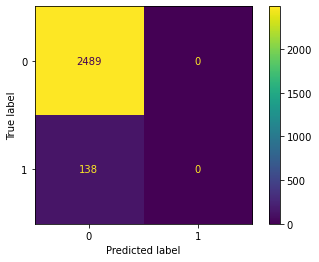

In [79]:
lr_predictions = lr.predict(X_test_sc)

lr_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, lr_predictions, labels=lr.classes_), 
                              display_labels=lr.classes_)
lr_disp.plot();

### XGBoost Classifier

In [80]:
%%time

# Instantiate the model
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state = 42)

# Fit the model
xgb.fit(X_train, y_train)

[22:26:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 551 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [81]:
# print the summarize report and store the values
run_score(xgb, 'XGBClassifier', scale=False)

====== XGBClassifier's Metrics ======
Train Score: 0.9610356644244193
Test Score: 0.9440426341834792
Precision Score: 0.42105263157894735
Recall Score: 0.17391304347826086
Average Precision: 0.11662205280666621
f1-Score: 0.24615384615384617
roc_auc Score: 0.8254857605347589

== confusion matrix ==
True Negatives: 2456
False Positives: 33
False Negatives: 114
True Positives: 24


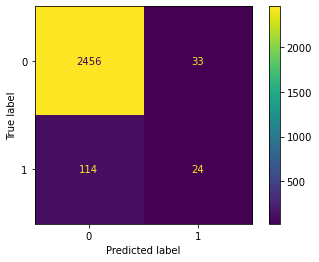

In [82]:
# plot confusion matrix
xgb_predictions = xgb.predict(X_test)

xgb_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, xgb_predictions, labels=xgb.classes_), 
                              display_labels=xgb.classes_)
xgb_disp.plot();

In summary, XGB manage to outperform logistic regression model with better accuracy, f1-score, recall score as well as precision score. The XGB also obtain the around 82% in roc auc score.

### Modeling Using PyCaret

To improve our efficiency and effectiveness on our modeling process, we decided to go for PyCaret which will cover majority of classifier algorithms

In [83]:
df_train = train_final
df_test = test_final_no_index

In [84]:
# PyCaret did not define all the categorical variables correctly so a list of the categorical variables is created.

cat_features = ['species', 'month', 'week', 'day', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9',
       'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14',
       'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19',
       'cluster_20', 'cluster_21', 'cluster_22', 'cluster_23', 'cluster_24',
       'cluster_25', 'cluster_26', 'cluster_27', 'cluster_28', 'cluster_29',
       'cluster_30', 'cluster_31', 'cluster_32', 'cluster_33', 'cluster_34',
       'cluster_35', 'cluster_36', 'cluster_37']

In [85]:
# Use a classifier from PyCaret
from pycaret.classification import *
from imblearn.combine import SMOTETomek
smtom = SMOTETomek(sampling_strategy='minority')

# Set up an experiment for PyCaret
clf = setup(
      data = df_train,
      target = 'wnvpresent',
      session_id = 1,
      categorical_features = cat_features,
      fix_imbalance = True)

,Description,Value
0,session_id,1
1,Target,wnvpresent
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(10506, 58)"
5,Missing Values,False
6,Numeric Features,15
7,Categorical Features,42
8,Ordinal Features,False
9,High Cardinality Features,False


In [86]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [87]:
best_model = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9153,0.8286,0.3442,0.2742,0.3043,0.2601,0.2623,0.3970
xgboost,Extreme Gradient Boosting,0.9161,0.8222,0.3289,0.2721,0.2965,0.2526,0.2545,1.4520
gbc,Gradient Boosting Classifier,0.8534,0.8108,0.5405,0.1925,0.2835,0.2223,0.2593,1.1390
lr,Logistic Regression,0.7297,0.8099,0.7344,0.1331,0.2252,0.1483,0.2289,1.3700
lda,Linear Discriminant Analysis,0.7207,0.8094,0.7547,0.1317,0.2242,0.1468,0.2312,0.2170
ada,Ada Boost Classifier,0.8134,0.7893,0.5607,0.1564,0.2441,0.1753,0.2223,0.2680
rf,Random Forest Classifier,0.9120,0.7730,0.2933,0.2401,0.2632,0.2171,0.2187,0.3340
knn,K Neighbors Classifier,0.7847,0.7278,0.5330,0.1295,0.2083,0.1341,0.1800,0.1000
nb,Naive Bayes,0.4379,0.6834,0.9182,0.0807,0.1484,0.0559,0.1514,0.0380
et,Extra Trees Classifier,0.9109,0.6772,0.3009,0.2397,0.2658,0.2193,0.2214,0.4880


The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes. For this problem, we want to clearly identify the true positive and the true negatives so we optimize AUC.

Basline score is provided by dummy classifier which has a AUC of 0.5
Best model is lightgbm of 0.8260

In [88]:
best = automl(optimize = 'AUC')
best

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Using Pycaret optimization for the best model which is lightgbm.

In [89]:
predicted_prob = predict_model(best, df_test)
predicted_prob

,species,latitude,longitude,month,week,day,tmax,tmin,tavg,dewpoint,...,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35,cluster_36,cluster_37,Label,Score
0,2.0,41.954690,-87.800991,6,24,11,86.0,63.5,74.75,55.5,...,0,0,0,0,0,0,0,0,0,0.9991
1,1.0,41.954690,-87.800991,6,24,11,86.0,63.5,74.75,55.5,...,0,0,0,0,0,0,0,0,0,0.9991
2,2.0,41.954690,-87.800991,6,24,11,86.0,63.5,74.75,55.5,...,0,0,0,0,0,0,0,0,0,0.9991
3,0.0,41.954690,-87.800991,6,24,11,86.0,63.5,74.75,55.5,...,0,0,0,0,0,0,0,0,0,0.9996
4,0.0,41.954690,-87.800991,6,24,11,86.0,63.5,74.75,55.5,...,0,0,0,0,0,0,0,0,0,0.9996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,0.0,41.925652,-87.633590,10,40,2,73.5,64.5,69.00,62.0,...,0,0,0,0,0,0,0,0,0,0.9980
116289,0.0,41.925652,-87.633590,10,40,2,73.5,64.5,69.00,62.0,...,0,0,0,0,0,0,0,0,0,0.9980
116290,0.0,41.925652,-87.633590,10,40,2,73.5,64.5,69.00,62.0,...,0,0,0,0,0,0,0,0,0,0.9980
116291,0.0,41.925652,-87.633590,10,40,2,73.5,64.5,69.00,62.0,...,0,0,0,0,0,0,0,0,0,0.9980


In [90]:
kaggle = pd.read_csv('../assets/test.csv')
kaggle = kaggle.join(predicted_prob)
kaggle = kaggle[['Id', 'Score']]
kaggle['WnvPresent'] = 1 - kaggle['Score']
kaggle.drop(columns=['Score'], inplace=True)
kaggle

,Id,WnvPresent
0,1,0.0009
1,2,0.0009
2,3,0.0009
3,4,0.0004
4,5,0.0004
...,...,...
116288,116289,0.0020
116289,116290,0.0020
116290,116291,0.0020
116291,116292,0.0020


In [91]:
kaggle.to_csv('../assets/kaggle_submission.csv', index = False)

Kaggle score of 0.74498

# 4. Model Evaluation

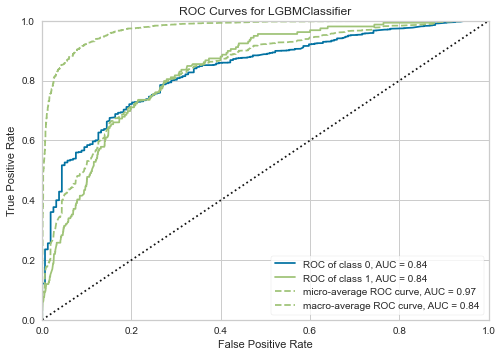

In [92]:
plot_model(best)

This is an imbalance dataset as the number of positive is much lower than the negative but the AUC for both is equal.

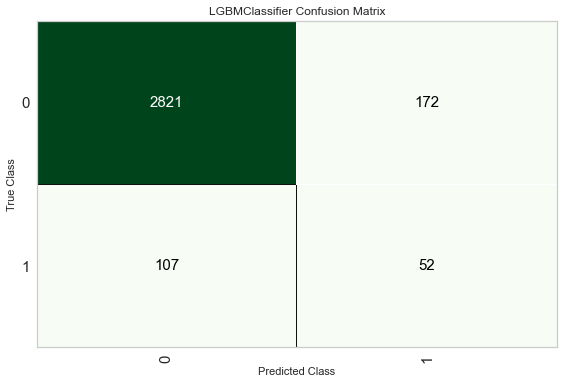

In [93]:
plot_model(best, plot = 'confusion_matrix')

The confusion matrix shows high TRUE Positive and high TRUE Negative however there are still 143 false positives and 46 false negatives which allows room for improvement.

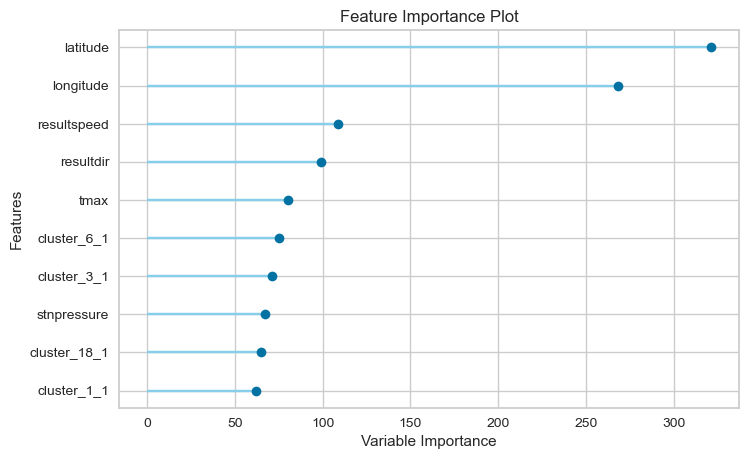

In [94]:
plot_model(best, plot = 'feature')

The most important features are latitude and longitude which is the location of the virus.

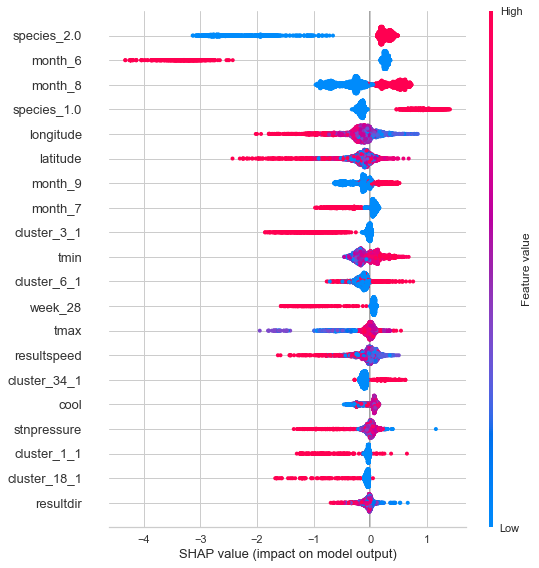

In [95]:
interpret_model(best)

Positive SHAP value means positive impact on prediction, leading the model to predict 1 and the highest features that contribute to positive are spieces_1.0 and longtitude.

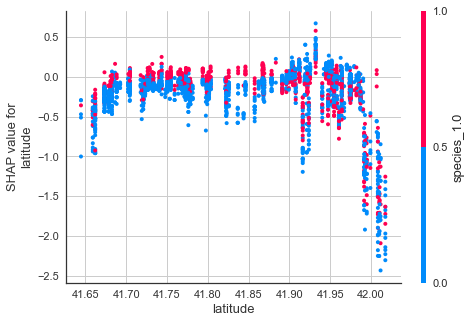

In [96]:
interpret_model(best, plot = 'correlation')

Longtitude and Latitude shows the highest correlation to the outcome variable.